In [26]:
import pickle
import warnings
import numpy as np
import pandas as pd
from PIL import Image
from pathlib import Path
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torchvision.utils as utils
import torchvision.transforms as transforms

import sklearn.exceptions
from sklearn.metrics import *
from sklearn.neighbors import NearestNeighbors
warnings.filterwarnings("ignore", category=sklearn.exceptions.UndefinedMetricWarning)

In [2]:
def load_dataset(file):
    with open(file, 'rb') as fo:
        file_output = pickle.load(fo, encoding='bytes')
    return file_output

In [3]:
if torch.cuda.is_available():
    dev = "cuda:0"
else:
    dev = "cpu"

In [4]:
train_data = load_dataset('/home/jhermosilla/Proyects/Datasets/cifar-100-python/train')
train_images = train_data[b'data']
train_images = train_images.reshape(-1, 3, 32, 32).transpose(0, 2, 3, 1)
train_labels = train_data[b'coarse_labels']

In [5]:
test_data = load_dataset('/home/jhermosilla/Proyects/Datasets/cifar-100-python/test')
test_images = test_data[b'data']
test_images = test_images.reshape(-1, 3, 32, 32).transpose(0, 2, 3, 1)
test_labels = test_data[b'coarse_labels']

In [6]:
train_stack = np.concatenate([np.asarray(train_images[i][0]) for i in range(len(train_images))])
train_mean = np.mean(train_stack, axis=(0, 1))/255
train_std = np.std(train_stack, axis=(0, 1))/255
train_mean=train_mean.tolist()
train_std=train_std.tolist()

In [7]:
test_stack = np.concatenate([np.asarray(test_images[i][0]) for i in range(len(test_images))])
test_mean = np.mean(test_stack, axis=(0, 1))/255
test_std = np.std(test_stack, axis=(0, 1))/255
test_mean=test_mean.tolist()
test_std=test_std.tolist()

In [8]:
superclass = ["aquatic mammals","fish","flowers","food containers","fruit and vegetables","household electrical devices","household furniture",
              "insects","large carnivores","large man-made outdoor things","large natural outdoor scenes","large omnivores and herbivores",
              "medium-sized mammals","non-insect invertebrates","people","reptiles","small mammals","trees","vehicles 1","vehicles 2"]

In [9]:
df_superclass = pd.DataFrame(superclass, columns=['Superclass'])
df_superclass

,Superclass
0,aquatic mammals
1,fish
2,flowers
3,food containers
4,fruit and vegetables
5,household electrical devices
6,household furniture
7,insects
8,large carnivores
9,large man-made outdoor things


In [10]:
class Data2Tuple(torch.utils.data.Dataset):
    def __init__(self, images, labels, transform=None):
        self.images = images
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]
        image = Image.fromarray(image)
        if self.transform:
            image = self.transform(image)
        return image, label

In [11]:
class LeNet5(nn.Module):
    def __init__(self):
        self.batch_size = 64
        self.train_set = Data2Tuple(train_images,
                                    train_labels,
                                    transforms.Compose([transforms.ToTensor(),
                                                        transforms.Normalize(train_mean,train_std,inplace=True)]))
        self.test_set  = Data2Tuple(test_images,
                                    test_labels,
                                    transforms.Compose([transforms.ToTensor(),
                                                        transforms.Normalize(test_mean,test_std)]))
        self.train_loader = torch.utils.data.DataLoader(dataset=self.train_set,
                                                        batch_size=self.batch_size,
                                                        shuffle=True,
                                                        pin_memory=True,
                                                        num_workers=2)
        self.test_loader  = torch.utils.data.DataLoader(dataset = self.test_set,
                                                        batch_size = self.batch_size*2,
                                                        shuffle = False,
                                                        pin_memory=True,
                                                        num_workers=2)
        super(LeNet5, self).__init__()
        self.convolution_layer1 = nn.Sequential(nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1),
                                                nn.Tanh(),
                                                nn.MaxPool2d(kernel_size = 2))
        self.convolution_layer2 = nn.Sequential(nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1),
                                                nn.Tanh(),
                                                nn.MaxPool2d(kernel_size = 2))
        self.convolution_layer3 = nn.Sequential(nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
                                                nn.Tanh(),
                                                nn.MaxPool2d(kernel_size = 2))
        self.convolution_layer4 = nn.Sequential(nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
                                                nn.Tanh(),
                                                nn.MaxPool2d(kernel_size = 2))

        self.fully_connected1 = nn.Sequential(nn.Flatten(),
                                              nn.Linear(128*2*2, 206))
        self.fully_connected2 = nn.Sequential(nn.Linear(206, 20),
                                              nn.Softmax(dim=1))
    def forward(self, x):
            out1 = self.convolution_layer1(x)
            out2 = self.convolution_layer2(out1)
            out3 = self.convolution_layer3(out2)
            out4 = self.convolution_layer4(out3)
            out5 = self.fully_connected1(out4)
            out6 = self.fully_connected2(out5)
            return out1, out4, out6

In [12]:
model = LeNet5()
model

LeNet5(
  (convolution_layer1): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): Tanh()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (convolution_layer2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): Tanh()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (convolution_layer3): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): Tanh()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (convolution_layer4): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): Tanh()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fully_connected1): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=512, out_features=206, bias=

In [13]:
class Learning_class():
    def __init__(self, model):
        self.epochs = 50
        self.device = torch.device(dev)
        self.model = model.to(self.device)
        self.loss_func = nn.CrossEntropyLoss()
        self.optimizer = torch.optim.Adam(self.model.parameters(),
                                          lr=0.0001,
                                          betas=(0.9, 0.999),
                                          eps=1e-08,
                                          weight_decay=0,
                                          amsgrad=False)
        self.model_path = Path("models")
        self.model_name = "lenet5.pth"
        self.model_path.mkdir(parents=True, exist_ok=True)
        self.full_path = self.model_path / self.model_name
        self.train_loss_hist = []
        self.train_acc_hist = []
        self.test_loss_hist = []
        self.test_acc_hist = []
        self.history = []
        self.actuals = []
        self.predictions = []
        
    def accuracy(self, predicted, labels):
        pred, predclassid=torch.max(predicted,dim=1)
        return torch.tensor(torch.sum(predclassid==labels).item()/len(labels))

    def train(self, history = False):
        for epoch in range(self.epochs):
            train_loss = 0.0
            train_accu = 0.0
            for images, labels in self.model.train_loader:
                images = images.to(self.device)
                labels = labels.to(self.device)
                self.model.train()
                _, _, outputs = self.model(images)
                loss = self.loss_func(outputs, labels)
                with torch.no_grad():
                    train_loss += loss.item()
                accuracy = self.accuracy(outputs, labels)
                train_accu += accuracy
                self.optimizer.zero_grad()
                loss.backward()
                self.optimizer.step()
            train_loss /= len(self.model.train_loader)
            train_accu /= len(self.model.train_loader)
    
            test_loss = 0.0
            test_accu = 0.0
            self.model.eval()
            with torch.inference_mode():
                for images, labels in self.model.test_loader:
                    images = images.to(self.device)
                    labels = labels.to(self.device)
                    _, _, outputs = self.model(images)
                    prediction = outputs.argmax(dim=1, keepdim=True)
                    self.actuals.extend(labels.view_as(prediction))
                    self.predictions.extend(prediction)
                    loss = self.loss_func(outputs,labels)
                    accuracy = self.accuracy(outputs, labels)
                    with torch.no_grad():
                        test_loss += loss.item()
                        test_accu += accuracy
                test_loss /= len(self.model.test_loader)
                test_accu /= len(self.model.test_loader)
            labels_test = [i.item() for i in self.actuals] 
            labels_pred = [i.item() for i in self.predictions]

            print(f"Epoch: {epoch+1} Train loss: {train_loss: .5f} Train acc: {train_accu: .5f} Test loss: {test_loss: .5f} Test acc: {test_accu: .5f}")
            if (history):
                self.train_loss_hist.append(train_loss)
                self.test_loss_hist.append(test_loss)
                self.train_acc_hist.append(train_accu)
                self.test_acc_hist.append(test_accu)

        self.history.append(self.train_loss_hist)
        self.history.append(self.test_loss_hist)
        self.history.append(self.train_acc_hist)
        self.history.append(self.test_acc_hist)
        return self.model, self.history

    def plot_loss(self, history):
        plt.figure(figsize=(5, 5))
        plt.plot(range(1,self.epochs+1),history[0], label='Train', color='red')
        plt.plot(range(1,self.epochs+1),history[1], label='Test', color='green')
        plt.title('Loss history')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()
        plt.savefig('loss.png', bbox_inches='tight')
        plt.show()
        
    def plot_accuracy(self, history):
        plt.figure(figsize=(5, 5))
        plt.plot(range(1,self.epochs+1),history[2], label='Train', color='red')
        plt.plot(range(1,self.epochs+1),history[3], label='Test', color='green')
        plt.title('Accuracy history')
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy')
        plt.legend()
        plt.savefig('accuracy.png', bbox_inches='tight')
        plt.show()

In [14]:
learning_model = Learning_class(model)
trained_model, history = learning_model.train(history=True)

Epoch: 1 Train loss:  2.91310 Train acc:  0.16278 Test loss:  2.88238 Test acc:  0.19492
Epoch: 2 Train loss:  2.86197 Train acc:  0.21731 Test loss:  2.84783 Test acc:  0.23250
Epoch: 3 Train loss:  2.83254 Train acc:  0.24816 Test loss:  2.82709 Test acc:  0.25316
Epoch: 4 Train loss:  2.81058 Train acc:  0.27150 Test loss:  2.80876 Test acc:  0.27304
Epoch: 5 Train loss:  2.79287 Train acc:  0.28894 Test loss:  2.79237 Test acc:  0.28758
Epoch: 6 Train loss:  2.77634 Train acc:  0.30587 Test loss:  2.77765 Test acc:  0.30261
Epoch: 7 Train loss:  2.76256 Train acc:  0.31987 Test loss:  2.76990 Test acc:  0.31161
Epoch: 8 Train loss:  2.75163 Train acc:  0.33146 Test loss:  2.76028 Test acc:  0.31992
Epoch: 9 Train loss:  2.74021 Train acc:  0.34473 Test loss:  2.75273 Test acc:  0.32931
Epoch: 10 Train loss:  2.72925 Train acc:  0.35552 Test loss:  2.74556 Test acc:  0.33604
Epoch: 11 Train loss:  2.71805 Train acc:  0.36793 Test loss:  2.73671 Test acc:  0.34345
Epoch: 12 Train los

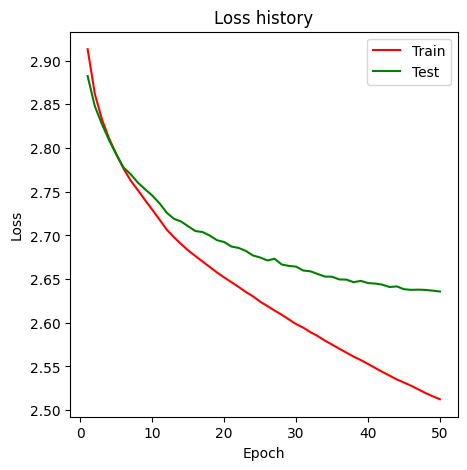

In [15]:
learning_model.plot_loss(history)

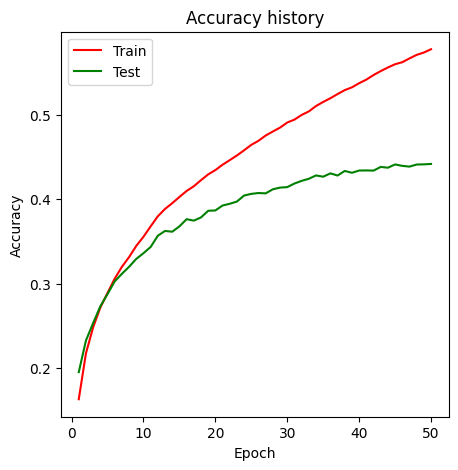

In [16]:
learning_model.plot_accuracy(history)

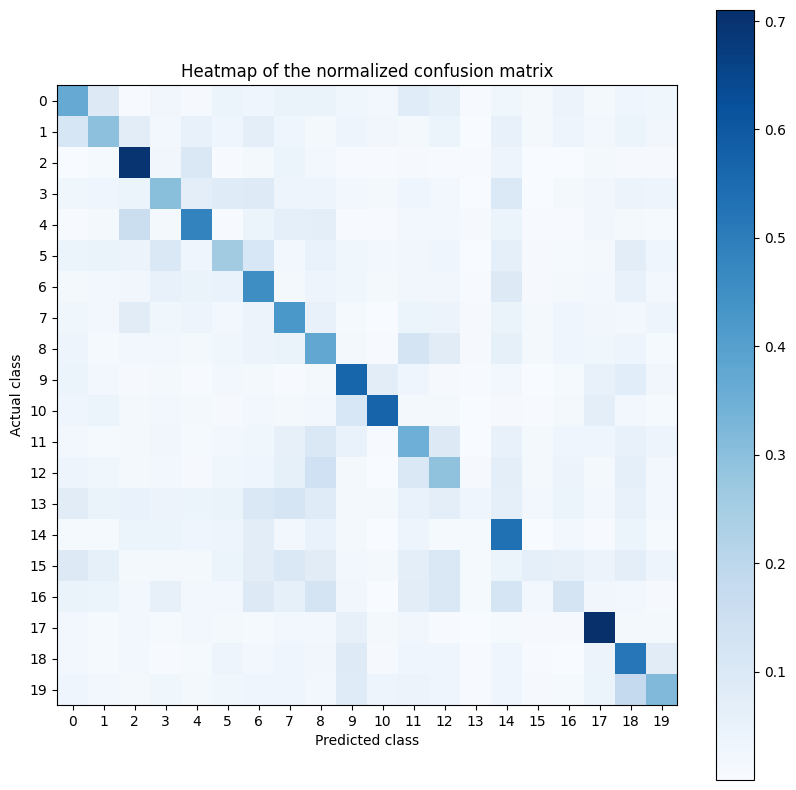

In [17]:
label_actuals = torch.tensor(learning_model.actuals, device = 'cpu')
label_predictions = torch.tensor(learning_model.predictions, device = 'cpu')
cm = confusion_matrix(label_actuals, label_predictions)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

fig, ax = plt.subplots(figsize=(10,10))
im = ax.imshow(cm_normalized, cmap=plt.cm.Blues)
ax.figure.colorbar(im, ax=ax)

ax.set(xticks=np.arange(cm.shape[1]),
       yticks=np.arange(cm.shape[0]),
       title='Heatmap of the normalized confusion matrix',
       ylabel='Actual class',
       xlabel='Predicted class')

plt.savefig('confusion.png', bbox_inches='tight')
plt.show()

In [18]:
cr=classification_report(label_actuals, label_predictions)
rs=recall_score(label_actuals, label_predictions, average='weighted', zero_division=0)
ac=accuracy_score(label_actuals, label_predictions)
print(cr)
print(f"  Recall {rs: .2f}")
print(f"Accuracy {ac: .2f}")

              precision    recall  f1-score   support

           0       0.35      0.36      0.36     25000
           1       0.36      0.30      0.32     25000
           2       0.52      0.70      0.59     25000
           3       0.35      0.30      0.32     25000
           4       0.47      0.48      0.47     25000
           5       0.32      0.26      0.28     25000
           6       0.33      0.45      0.38     25000
           7       0.34      0.43      0.38     25000
           8       0.27      0.38      0.32     25000
           9       0.47      0.57      0.51     25000
          10       0.68      0.57      0.62     25000
          11       0.30      0.35      0.32     25000
          12       0.27      0.29      0.28     25000
          13       0.25      0.03      0.05     25000
          14       0.36      0.53      0.43     25000
          15       0.27      0.06      0.10     25000
          16       0.23      0.13      0.16     25000
          17       0.58    

In [19]:
trained_model.to(torch.device('cpu'))
testing = trained_model.test_set
test_img = testing[1][0].unsqueeze(0)

In [20]:
layer1, layer4, output = trained_model(test_img)

In [21]:
def visualize_feature_maps(feature_maps,lx,ly, size,name):
    maps = feature_maps.shape[1]
    plt.figure(figsize=(size,size))
    for i in range(maps):
        plt.subplot(lx, ly, i+1)
        plt.imshow(feature_maps[0,i].detach().numpy(), cmap='binary')
        plt.title(i+1)
        plt.axis('off')
    plt.tight_layout()
    plt.savefig(str(name) + '.png', bbox_inches='tight')
    plt.show()

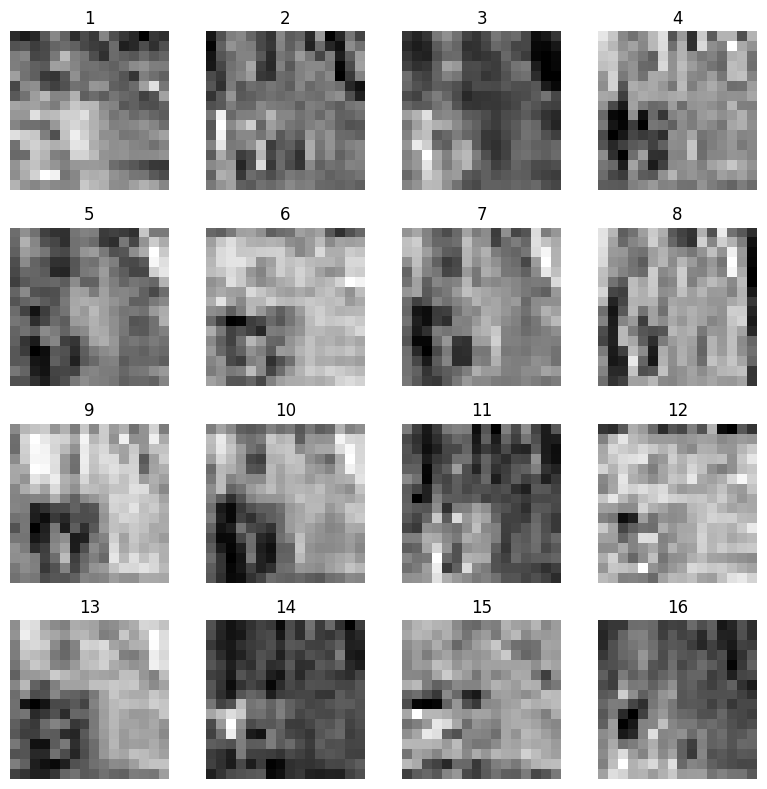

In [22]:
visualize_feature_maps(layer1,4,4,8,"layer1")

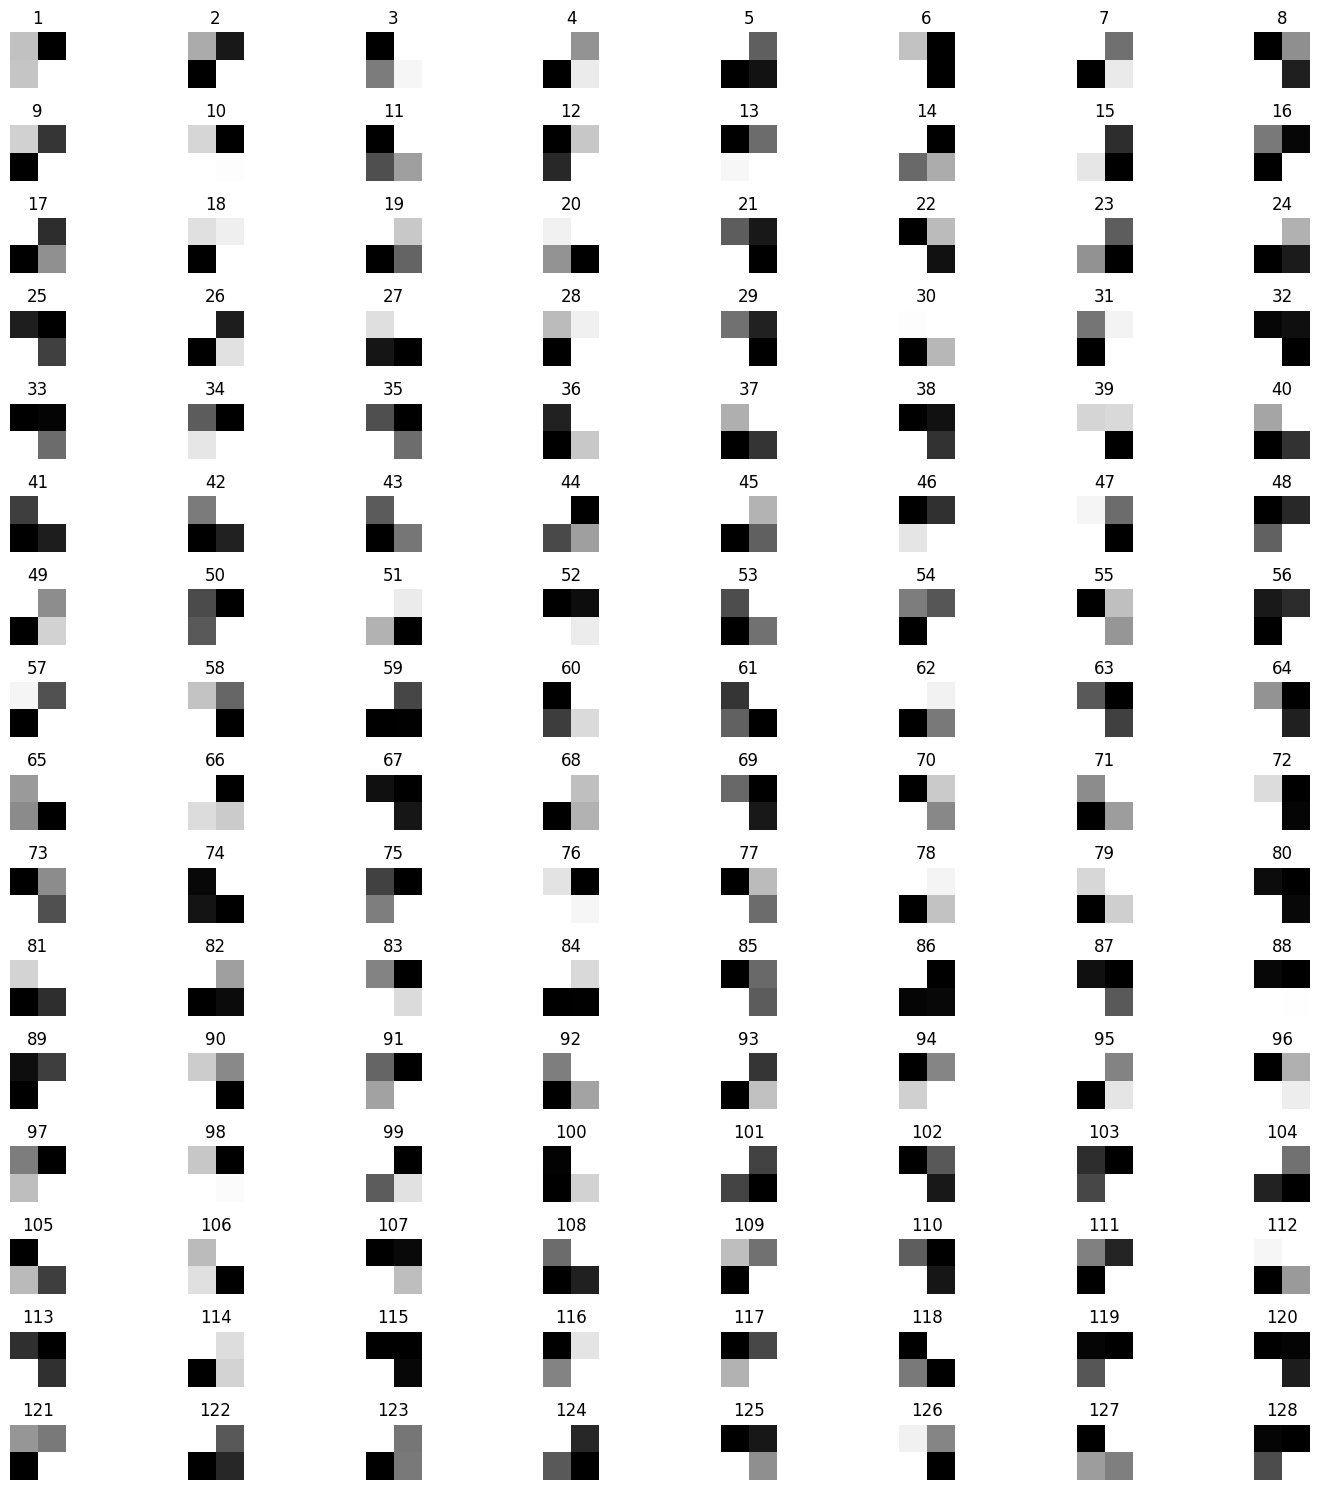

In [23]:
visualize_feature_maps(layer4,16,8,15,"layer4")

In [24]:
def kneighbors_cluster(model, neighbors, sample_size):
    model.eval()
    img_data = []
    all_img_data = []
    class_labels = []

    with torch.no_grad():
        for img_set, lbl_set in model.test_loader:
            img_data.append(img_set.view(img_set.size(0), -1))
            all_img_data.append(img_set)
            class_labels.append(lbl_set)

    all_img_data = torch.cat(all_img_data, dim=0).numpy()
    img_data = torch.cat(img_data, dim=0).cpu().numpy()
    class_labels = torch.cat(class_labels, dim=0).cpu().numpy()

    neighbor_search = NearestNeighbors(n_neighbors=neighbors + 1, metric='euclidean').fit(img_data)
    distances, indices = neighbor_search.kneighbors(img_data)

    indexs_lst = []
    for i in range(20):
        indx = np.array([np.where(class_labels == i)]).min()
        indexs_lst.append(indx)
    indexs_np = np.array(indexs_lst)
    fig, ax = plt.subplots(nrows=20, ncols=neighbors+1, figsize=(20, 40))
    for img_idx in indexs_np:
        main_image = all_img_data[img_idx].transpose(1, 2, 0) * test_std + test_mean
        ax[class_labels[img_idx], 0].imshow(main_image)
        ax[class_labels[img_idx], 0].set_title("Class: " + str(class_labels[img_idx]))
        ax[class_labels[img_idx], 0].axis('off')
        
        for nb_idx, nb in enumerate(indices[img_idx][1:]):
            neighbor_image = all_img_data[nb].transpose(1, 2, 0)* test_std + test_mean
            ax[class_labels[img_idx], nb_idx+1].imshow(neighbor_image)
            ax[class_labels[img_idx], nb_idx+1].set_title(class_labels[nb])
            ax[class_labels[img_idx], nb_idx+1].axis('off')
            
    fig.subplots_adjust(hspace=0.3)
    plt.savefig('cluster.png', bbox_inches='tight')
    plt.show()

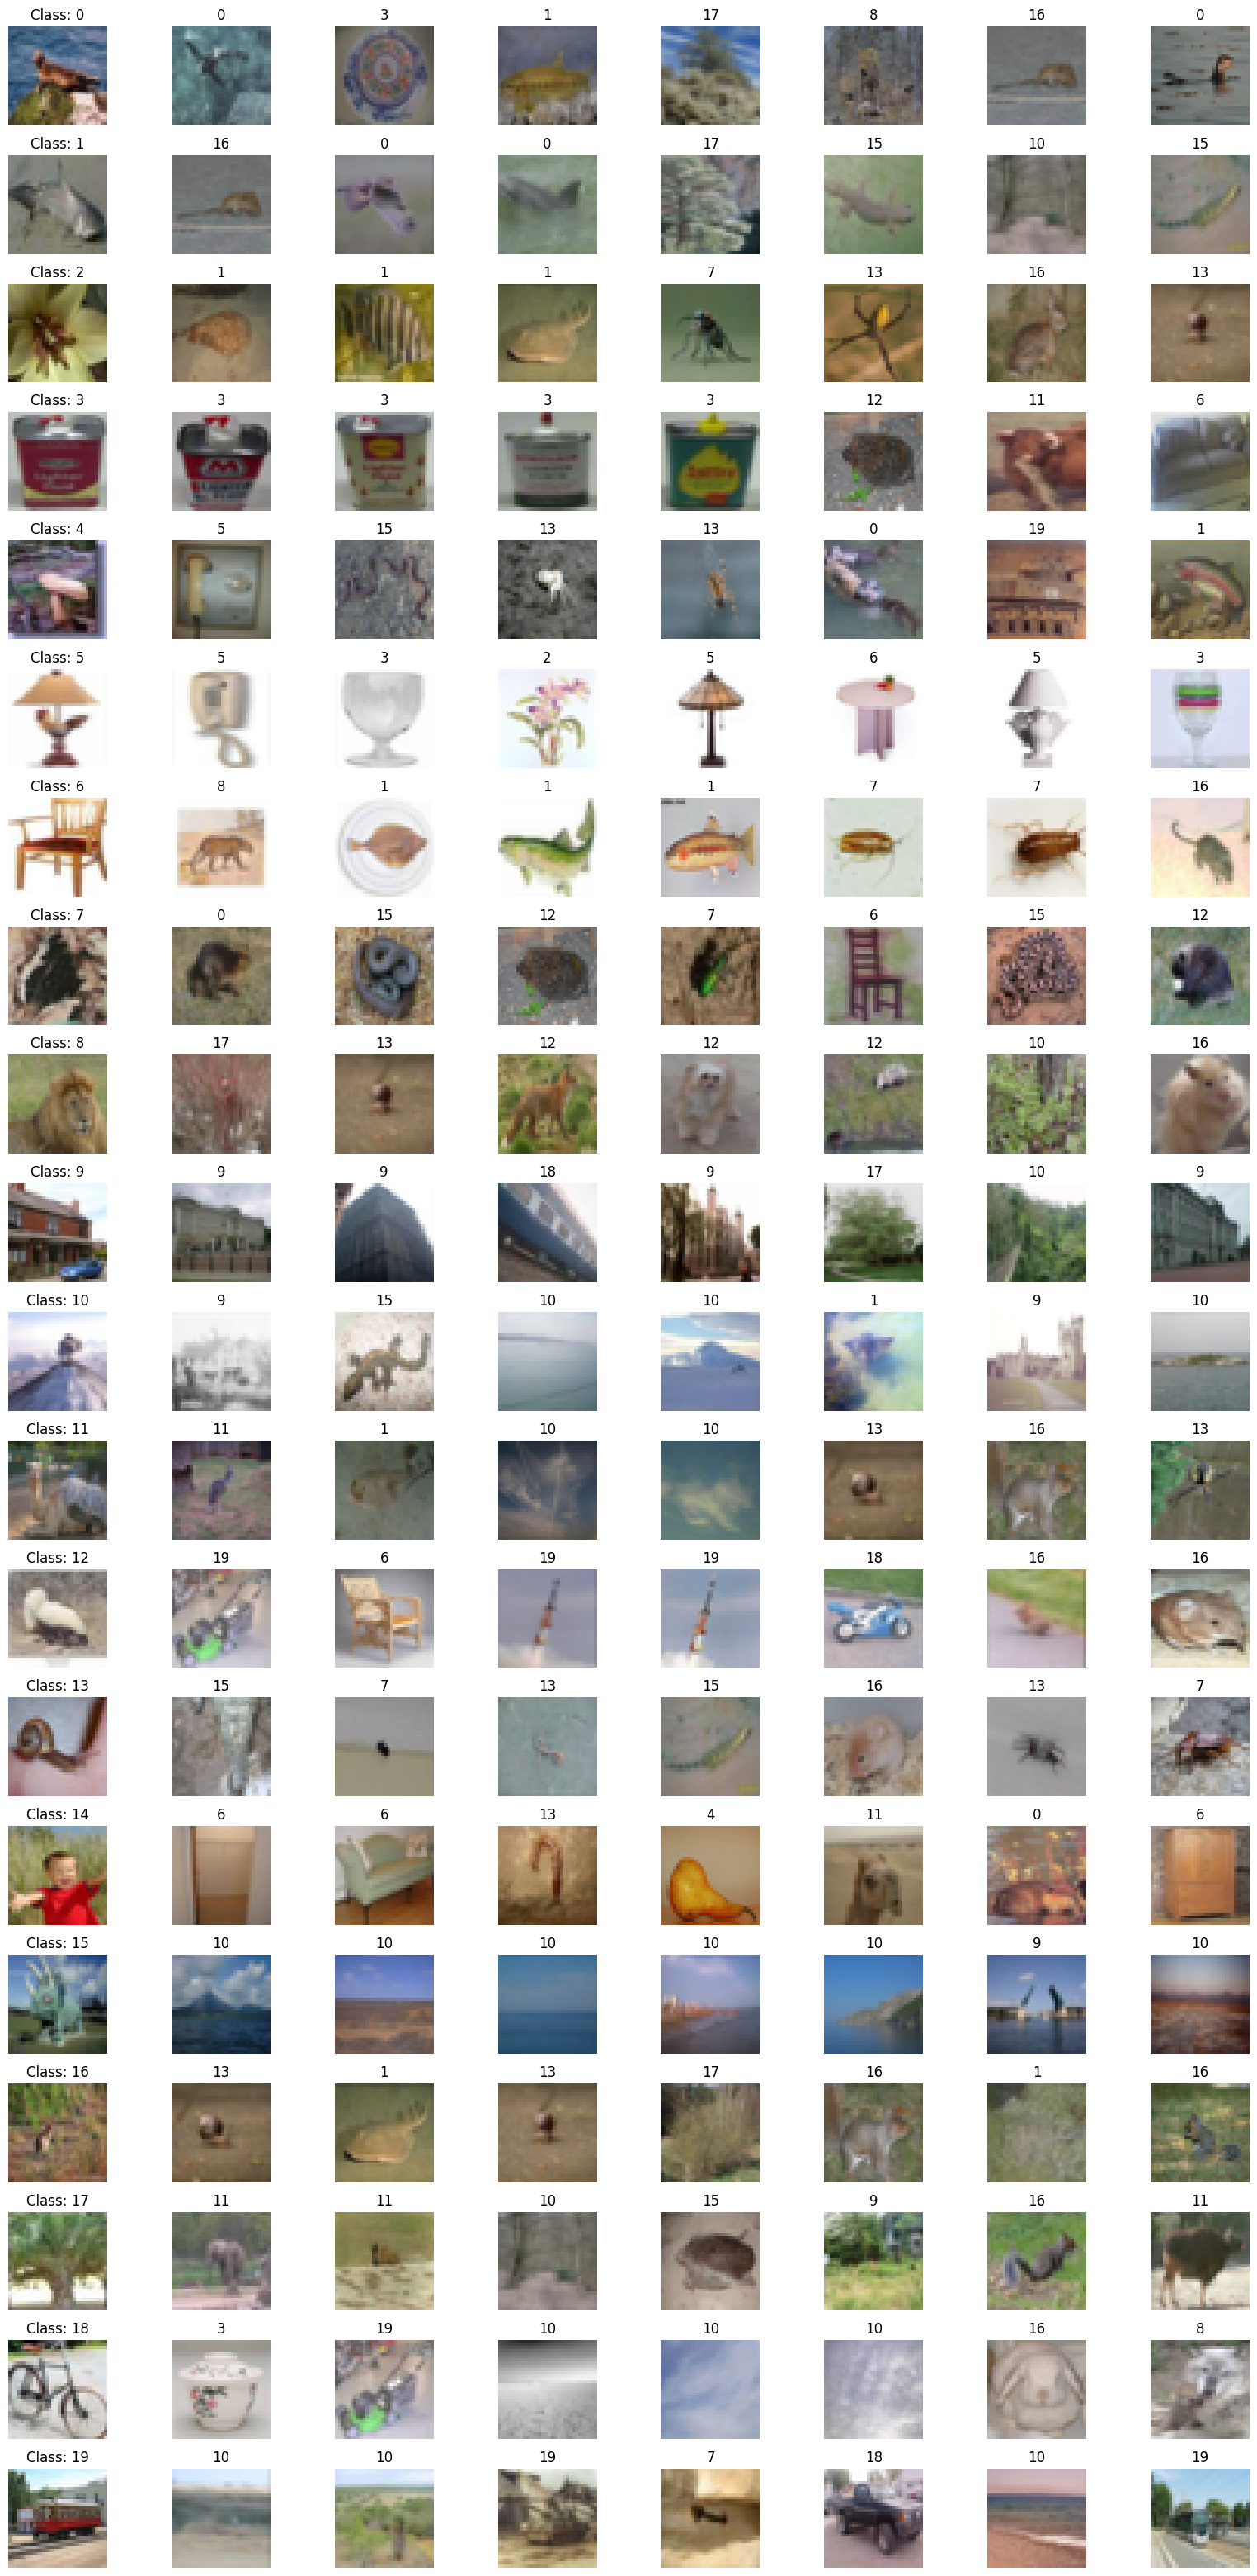

In [25]:
kneighbors_cluster(model,7,10)